In [1]:
# ============================================================================
# CELL 1: Import Libraries and Setup
# ============================================================================
!pip install swig
!pip install box2d-py
!pip install gymnasium[box2d]


import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp312-cp312-linux_x86_64.whl size=2409500 sha256=0ec90ecf96e1e25c22468c4943fbb2f5aa9c69514e23eb853ad02e080128541c
  Stored in directory: /root/.cache/pip/wheels/d6/3c/ab/b6fd75459cadc56f4a4125d4cb387a708a59ca8589e4cc6b7d
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409498 sha256=0fefc3c80dbdd1af87e0ae792dbaeeac2585de0650e47aef1e0662af06480199
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py
  Attempting uninstall: box2d-py
    Found existing installation: box2d-p

In [2]:

# ============================================================================
# CELL 2: Define Hyperparameters
# ============================================================================
class Config:
    ENV_NAME = 'LunarLander-v3'
    HIDDEN_SIZE_1 = 128
    HIDDEN_SIZE_2 = 128
    BATCH_SIZE = 64
    GAMMA = 0.99
    LEARNING_RATE = 5e-4
    REPLAY_BUFFER_SIZE = 100000
    MIN_REPLAY_SIZE = 1000
    EPSILON_START = 1.0
    EPSILON_END = 0.01
    EPSILON_DECAY = 0.995
    TARGET_UPDATE_FREQUENCY = 1000
    MAX_EPISODES = 600
    MAX_STEPS_PER_EPISODE = 1000

config = Config()
print("Hyperparameters loaded!")



Hyperparameters loaded!


In [3]:

# ============================================================================
# CELL 3: Define Q-Network Architecture
# ============================================================================
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden1=128, hidden2=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

env = gym.make(config.ENV_NAME)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(f"State size: {state_size}, Action size: {action_size}")
env.close()

State size: 8, Action size: 4


In [4]:
# ============================================================================
# CELL 4: Implement Experience Replay Buffer
# ============================================================================
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))

        states = torch.FloatTensor(np.array(batch.state)).to(device)
        actions = torch.LongTensor(batch.action).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(batch.reward).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(batch.next_state)).to(device)
        dones = torch.FloatTensor(batch.done).unsqueeze(1).to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

print("Replay Buffer created!")


Replay Buffer created!


In [5]:
# ============================================================================
# CELL 5: Implement DQN Agent
# ============================================================================
class DQNAgent:
    def __init__(self, state_size, action_size, config, use_replay=True, use_target=True):
        self.state_size = state_size
        self.action_size = action_size
        self.config = config
        self.use_replay = use_replay
        self.use_target = use_target

        # Online Q-Network
        self.q_network = QNetwork(state_size, action_size,
                                   config.HIDDEN_SIZE_1, config.HIDDEN_SIZE_2).to(device)

        # Target Q-Network
        if self.use_target:
            self.target_network = QNetwork(state_size, action_size,
                                          config.HIDDEN_SIZE_1, config.HIDDEN_SIZE_2).to(device)
            self.target_network.load_state_dict(self.q_network.state_dict())
            self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=config.LEARNING_RATE)

        if self.use_replay:
            self.replay_buffer = ReplayBuffer(config.REPLAY_BUFFER_SIZE)

        self.epsilon = config.EPSILON_START
        self.steps = 0
        self.losses = []

    def select_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        if self.use_replay:
            self.replay_buffer.push(state, action, reward, next_state, done)

    def train_step(self):
        if self.use_replay:
            if len(self.replay_buffer) < self.config.MIN_REPLAY_SIZE:
                return None
            states, actions, rewards, next_states, dones = self.replay_buffer.sample(
                self.config.BATCH_SIZE)
        else:
            return None

        current_q_values = self.q_network(states).gather(1, actions)

        with torch.no_grad():
            if self.use_target:
                next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            else:
                next_q_values = self.q_network(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.config.GAMMA * next_q_values

        loss = F.mse_loss(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        self.losses.append(loss.item())
        self.steps += 1

        if self.use_target and self.steps % self.config.TARGET_UPDATE_FREQUENCY == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        return loss.item()

    def decay_epsilon(self):
        self.epsilon = max(self.config.EPSILON_END,
                          self.epsilon * self.config.EPSILON_DECAY)

print("DQN Agent class created!")


DQN Agent class created!


In [6]:
# ============================================================================
# CELL 6: Training Function
# ============================================================================
def train_dqn(agent, env, config, agent_name="DQN"):
    episode_rewards = []
    episode_epsilons = []

    print(f"Training {agent_name}...")

    for episode in range(config.MAX_EPISODES):
        state, _ = env.reset()
        episode_reward = 0

        for step in range(config.MAX_STEPS_PER_EPISODE):
            action = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.store_transition(state, action, reward, next_state, done)
            agent.train_step()

            episode_reward += reward
            state = next_state

            if done:
                break

        agent.decay_epsilon()
        episode_rewards.append(episode_reward)
        episode_epsilons.append(agent.epsilon)

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {episode + 1}/{config.MAX_EPISODES} | "
                  f"Reward: {episode_reward:.2f} | Avg: {avg_reward:.2f} | "
                  f"Epsilon: {agent.epsilon:.4f}")

    return episode_rewards, episode_epsilons, agent.losses

print("Training function defined!")


Training function defined!


In [7]:
# ============================================================================
# CELL 7: Train Full DQN (with Experience Replay and Target Network)
# ============================================================================
print("\n" + "="*70)
print("TRAINING: Full DQN (WITH Experience Replay + Target Network)")
print("="*70)

env = gym.make(config.ENV_NAME)
agent_full = DQNAgent(state_size, action_size, config, use_replay=True, use_target=True)
rewards_full, epsilons_full, losses_full = train_dqn(agent_full, env, config, "Full DQN")
env.close()

print(f"\nTraining complete! Final avg reward: {np.mean(rewards_full[-100:]):.2f}")


TRAINING: Full DQN (WITH Experience Replay + Target Network)
Training Full DQN...
Episode 50/600 | Reward: -90.84 | Avg: -133.38 | Epsilon: 0.7783
Episode 100/600 | Reward: -102.23 | Avg: -112.89 | Epsilon: 0.6058
Episode 150/600 | Reward: -29.71 | Avg: -71.46 | Epsilon: 0.4715
Episode 200/600 | Reward: 69.17 | Avg: -42.68 | Epsilon: 0.3670
Episode 250/600 | Reward: -8.82 | Avg: 8.18 | Epsilon: 0.2856
Episode 300/600 | Reward: 118.68 | Avg: 85.73 | Epsilon: 0.2223
Episode 350/600 | Reward: 133.09 | Avg: 146.67 | Epsilon: 0.1730
Episode 400/600 | Reward: 260.38 | Avg: 165.72 | Epsilon: 0.1347
Episode 450/600 | Reward: -12.37 | Avg: 182.15 | Epsilon: 0.1048
Episode 500/600 | Reward: 301.59 | Avg: 215.76 | Epsilon: 0.0816
Episode 550/600 | Reward: 290.71 | Avg: 234.61 | Epsilon: 0.0635
Episode 600/600 | Reward: 301.58 | Avg: 238.47 | Epsilon: 0.0494

Training complete! Final avg reward: 238.47


In [8]:
# ============================================================================
# CELL 8: Train DQN without Experience Replay
# ============================================================================
print("\n" + "="*70)
print("TRAINING: DQN WITHOUT Experience Replay")
print("="*70)

env_no_replay = gym.make(config.ENV_NAME)
agent_no_replay = DQNAgent(state_size, action_size, config, use_replay=False, use_target=True)

rewards_no_replay = []
epsilons_no_replay = []

for episode in range(config.MAX_EPISODES):
    state, _ = env_no_replay.reset()
    episode_reward = 0

    for step in range(config.MAX_STEPS_PER_EPISODE):
        action = agent_no_replay.select_action(state, training=True)
        next_state, reward, terminated, truncated, _ = env_no_replay.step(action)
        done = terminated or truncated
        episode_reward += reward
        state = next_state
        if done:
            break

    agent_no_replay.decay_epsilon()
    rewards_no_replay.append(episode_reward)
    epsilons_no_replay.append(agent_no_replay.epsilon)

    if (episode + 1) % 50 == 0:
        avg = np.mean(rewards_no_replay[-100:]) if len(rewards_no_replay) >= 100 else np.mean(rewards_no_replay)
        print(f"Episode {episode + 1}/{config.MAX_EPISODES} | Reward: {episode_reward:.2f} | Avg: {avg:.2f}")

env_no_replay.close()
print(f"\nTraining complete! Final avg reward: {np.mean(rewards_no_replay[-100:]):.2f}")


TRAINING: DQN WITHOUT Experience Replay
Episode 50/600 | Reward: -139.28 | Avg: -187.47
Episode 100/600 | Reward: -125.73 | Avg: -171.94
Episode 150/600 | Reward: -403.05 | Avg: -159.48
Episode 200/600 | Reward: -199.96 | Avg: -156.68
Episode 250/600 | Reward: -100.68 | Avg: -154.40
Episode 300/600 | Reward: -97.80 | Avg: -144.98
Episode 350/600 | Reward: -123.22 | Avg: -134.91
Episode 400/600 | Reward: -124.99 | Avg: -140.01
Episode 450/600 | Reward: -107.00 | Avg: -140.95
Episode 500/600 | Reward: -45.64 | Avg: -131.50
Episode 550/600 | Reward: -119.30 | Avg: -134.91
Episode 600/600 | Reward: -162.05 | Avg: -141.58

Training complete! Final avg reward: -141.58


In [9]:
# ============================================================================
# CELL 9: Train DQN without Target Network
# ============================================================================
print("\n" + "="*70)
print("TRAINING: DQN WITHOUT Target Network")
print("="*70)

env_no_target = gym.make(config.ENV_NAME)
agent_no_target = DQNAgent(state_size, action_size, config, use_replay=True, use_target=False)
rewards_no_target, epsilons_no_target, losses_no_target = train_dqn(
    agent_no_target, env_no_target, config, "DQN without Target")
env_no_target.close()

print(f"\nTraining complete! Final avg reward: {np.mean(rewards_no_target[-100:]):.2f}")



TRAINING: DQN WITHOUT Target Network
Training DQN without Target...
Episode 50/600 | Reward: -104.32 | Avg: -134.97 | Epsilon: 0.7783
Episode 100/600 | Reward: -67.06 | Avg: -114.59 | Epsilon: 0.6058
Episode 150/600 | Reward: 38.12 | Avg: -70.53 | Epsilon: 0.4715
Episode 200/600 | Reward: 115.97 | Avg: -30.20 | Epsilon: 0.3670
Episode 250/600 | Reward: 169.25 | Avg: 25.85 | Epsilon: 0.2856
Episode 300/600 | Reward: 202.84 | Avg: 66.58 | Epsilon: 0.2223
Episode 350/600 | Reward: 31.76 | Avg: 114.26 | Epsilon: 0.1730
Episode 400/600 | Reward: 296.31 | Avg: 182.64 | Epsilon: 0.1347
Episode 450/600 | Reward: -81.66 | Avg: 205.68 | Epsilon: 0.1048
Episode 500/600 | Reward: 262.87 | Avg: 211.25 | Epsilon: 0.0816
Episode 550/600 | Reward: 260.85 | Avg: 233.30 | Epsilon: 0.0635
Episode 600/600 | Reward: 276.63 | Avg: 250.53 | Epsilon: 0.0494

Training complete! Final avg reward: 250.53


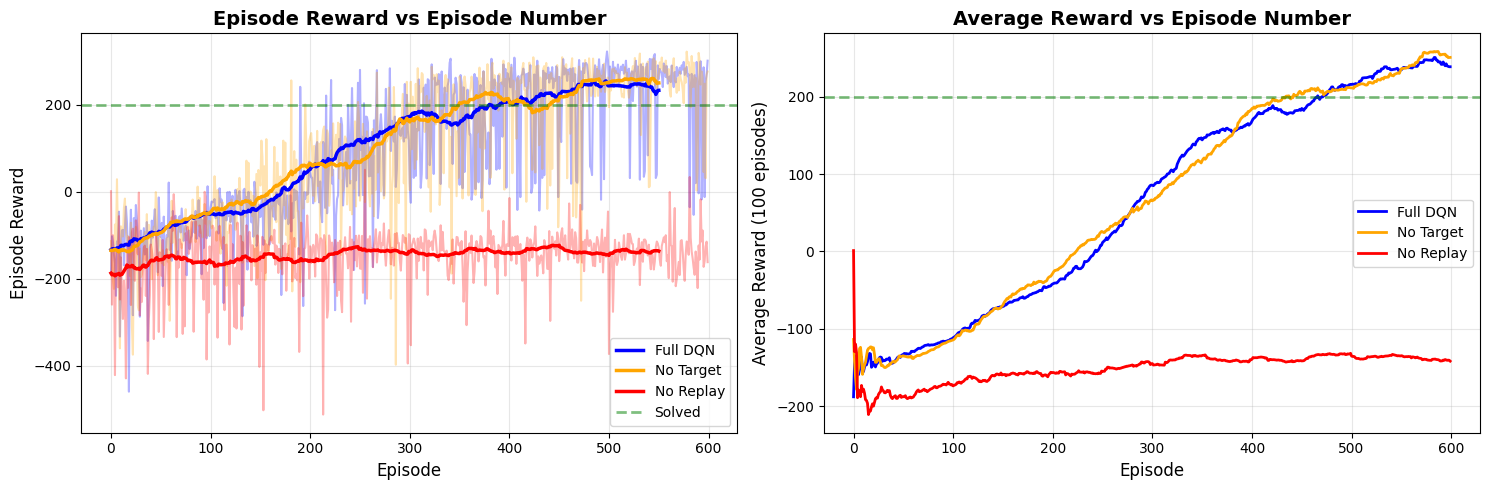

In [10]:
# ============================================================================
# CELL 10: Plot Episode Rewards vs Episode Number
# ============================================================================
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_full, alpha=0.3, color='blue')
plt.plot(rewards_no_target, alpha=0.3, color='orange')
plt.plot(rewards_no_replay, alpha=0.3, color='red')

window = 50
plt.plot(np.convolve(rewards_full, np.ones(window)/window, mode='valid'),
         label='Full DQN', color='blue', linewidth=2.5)
plt.plot(np.convolve(rewards_no_target, np.ones(window)/window, mode='valid'),
         label='No Target', color='orange', linewidth=2.5)
plt.plot(np.convolve(rewards_no_replay, np.ones(window)/window, mode='valid'),
         label='No Replay', color='red', linewidth=2.5)

plt.axhline(y=200, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Solved')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Episode Reward', fontsize=12)
plt.title('Episode Reward vs Episode Number', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
avg_full = [np.mean(rewards_full[max(0, i-99):i+1]) for i in range(len(rewards_full))]
avg_no_target = [np.mean(rewards_no_target[max(0, i-99):i+1]) for i in range(len(rewards_no_target))]
avg_no_replay = [np.mean(rewards_no_replay[max(0, i-99):i+1]) for i in range(len(rewards_no_replay))]

plt.plot(avg_full, label='Full DQN', color='blue', linewidth=2)
plt.plot(avg_no_target, label='No Target', color='orange', linewidth=2)
plt.plot(avg_no_replay, label='No Replay', color='red', linewidth=2)
plt.axhline(y=200, color='green', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average Reward (100 episodes)', fontsize=12)
plt.title('Average Reward vs Episode Number', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

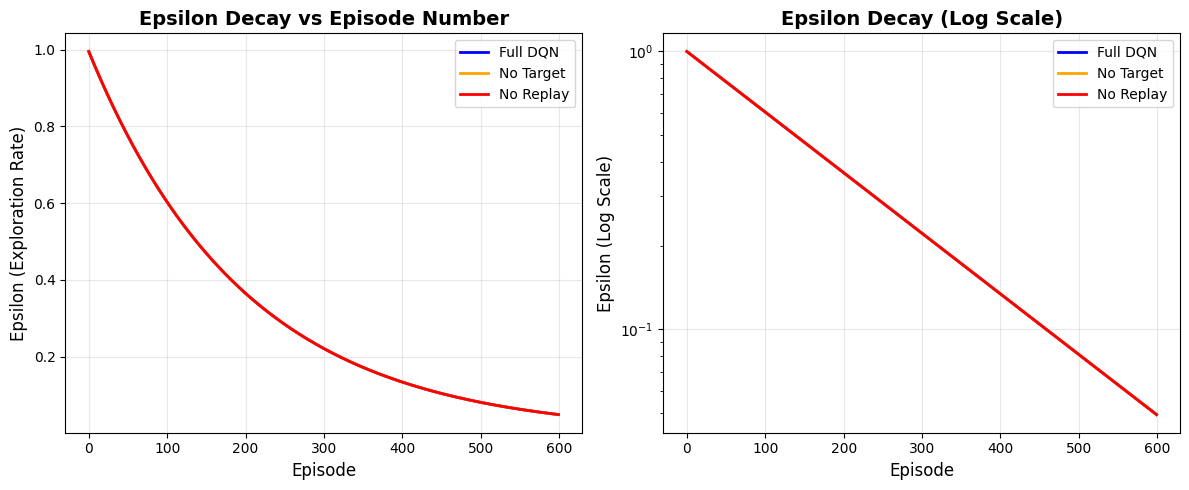

Final Epsilon Values:
Full DQN: 0.049414
No Target: 0.049414
No Replay: 0.049414


In [11]:
# ============================================================================
# CELL 11: Plot Epsilon Value vs Episode Number
# ============================================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epsilons_full, label='Full DQN', color='blue', linewidth=2)
plt.plot(epsilons_no_target, label='No Target', color='orange', linewidth=2)
plt.plot(epsilons_no_replay, label='No Replay', color='red', linewidth=2)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Epsilon (Exploration Rate)', fontsize=12)
plt.title('Epsilon Decay vs Episode Number', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(epsilons_full, label='Full DQN', color='blue', linewidth=2)
plt.semilogy(epsilons_no_target, label='No Target', color='orange', linewidth=2)
plt.semilogy(epsilons_no_replay, label='No Replay', color='red', linewidth=2)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Epsilon (Log Scale)', fontsize=12)
plt.title('Epsilon Decay (Log Scale)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Epsilon Values:")
print(f"Full DQN: {epsilons_full[-1]:.6f}")
print(f"No Target: {epsilons_no_target[-1]:.6f}")
print(f"No Replay: {epsilons_no_replay[-1]:.6f}")


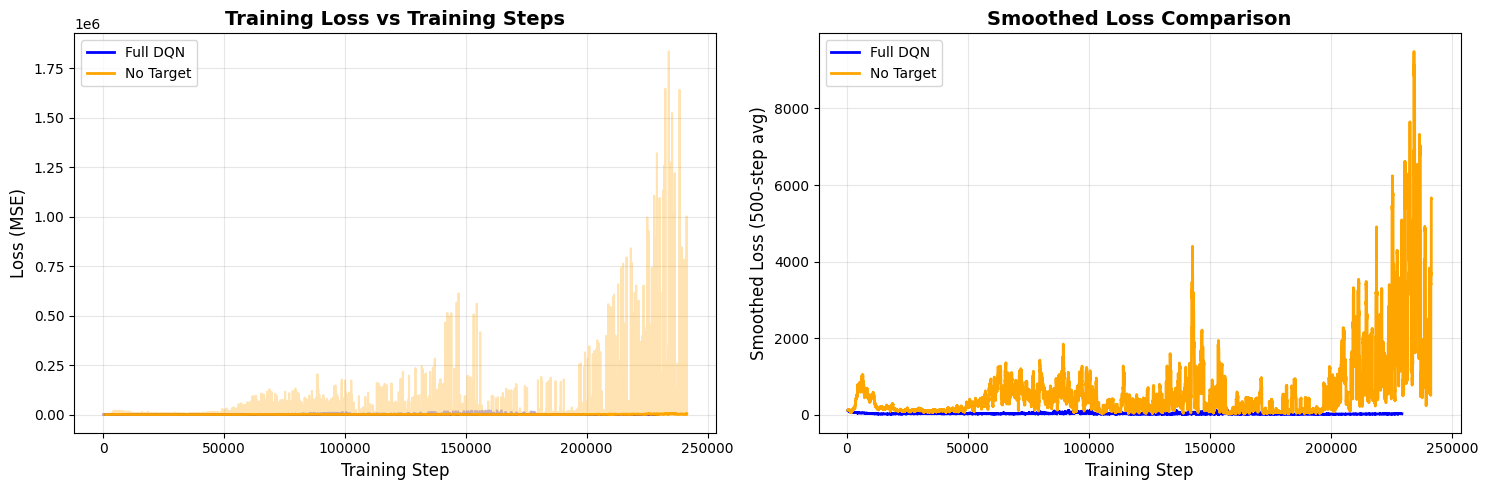


Loss Statistics:
Full DQN - Mean: 33.382489, Final 1000: 28.291865
No Target - Mean: 660.386462, Final 1000: 3711.749926


In [12]:
# ============================================================================
# CELL 12: Plot Loss vs Training Steps
# ============================================================================
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
if len(losses_full) > 0:
    plt.plot(losses_full, alpha=0.3, color='blue')
    window = 1000
    if len(losses_full) >= window:
        loss_smooth = np.convolve(losses_full, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(losses_full)), loss_smooth,
                label='Full DQN', color='blue', linewidth=2)

if len(losses_no_target) > 0:
    plt.plot(losses_no_target, alpha=0.3, color='orange')
    if len(losses_no_target) >= window:
        loss_smooth = np.convolve(losses_no_target, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(losses_no_target)), loss_smooth,
                label='No Target', color='orange', linewidth=2)

plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss vs Training Steps', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
window = 500
if len(losses_full) >= window:
    loss_smooth = np.convolve(losses_full, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(losses_full)), loss_smooth,
            label='Full DQN', color='blue', linewidth=2)

if len(losses_no_target) >= window:
    loss_smooth = np.convolve(losses_no_target, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(losses_no_target)), loss_smooth,
            label='No Target', color='orange', linewidth=2)

plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Smoothed Loss (500-step avg)', fontsize=12)
plt.title('Smoothed Loss Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLoss Statistics:")
print(f"Full DQN - Mean: {np.mean(losses_full):.6f}, Final 1000: {np.mean(losses_full[-1000:]):.6f}")
print(f"No Target - Mean: {np.mean(losses_no_target):.6f}, Final 1000: {np.mean(losses_no_target[-1000:]):.6f}")


PERFORMANCE COMPARISON


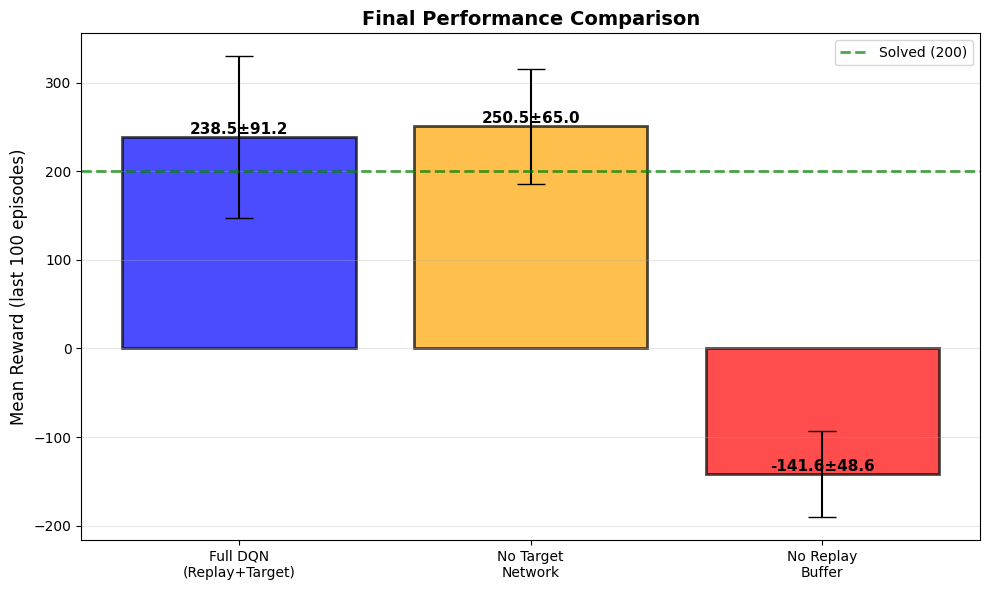


Final Results (Last 100 Episodes):
Full DQN:      238.47 ± 91.17
No Target:     250.53 ± 65.01
No Replay:     -141.58 ± 48.60

Impact of Experience Replay: +380.05
Impact of Target Network:    -12.07


In [13]:
# ============================================================================
# CELL 13: Performance Comparison
# ============================================================================
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

methods = ['Full DQN\n(Replay+Target)', 'No Target\nNetwork', 'No Replay\nBuffer']
final_avgs = [
    np.mean(rewards_full[-100:]),
    np.mean(rewards_no_target[-100:]),
    np.mean(rewards_no_replay[-100:])
]
final_stds = [
    np.std(rewards_full[-100:]),
    np.std(rewards_no_target[-100:]),
    np.std(rewards_no_replay[-100:])
]

plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'red']
bars = plt.bar(methods, final_avgs, yerr=final_stds, capsize=10,
               color=colors, alpha=0.7, edgecolor='black', linewidth=2)

plt.axhline(y=200, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Solved (200)')
plt.ylabel('Mean Reward (last 100 episodes)', fontsize=12)
plt.title('Final Performance Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

for bar, avg, std in zip(bars, final_avgs, final_stds):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{avg:.1f}±{std:.1f}', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nFinal Results (Last 100 Episodes):")
print(f"Full DQN:      {final_avgs[0]:.2f} ± {final_stds[0]:.2f}")
print(f"No Target:     {final_avgs[1]:.2f} ± {final_stds[1]:.2f}")
print(f"No Replay:     {final_avgs[2]:.2f} ± {final_stds[2]:.2f}")
print(f"\nImpact of Experience Replay: {final_avgs[0] - final_avgs[2]:+.2f}")
print(f"Impact of Target Network:    {final_avgs[0] - final_avgs[1]:+.2f}")
print("="*70)